In [1]:
import keras
from keras.layers import Input, Dense, Flatten, Conv1D, GRU, Dropout
from keras.models import load_model, Model
from sklearn.metrics import roc_curve, auc
import numpy as np
import os
import h5py
import yaml
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.regularizers import l1
from collections import namedtuple
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from train import parse_config, get_features

from models.models import gru_model

Using TensorFlow backend.


In [2]:
Option = namedtuple("MyStruct", "inputModel inputFile tree config  outputDir ")
options = Option(
    inputModel = 'KERAS_gru_model_weights.h5',
    inputFile = 'fixed.z',
    tree = 't_allpar_new',
    config = 'train_config_gru.yml',
    #jsonModel = 'KERAS_lstm_model.json',
    outputDir = 'output'
)

print("Loading configuration from", options.config)
config = open(options.config, 'r')

yamlConfig =  yaml.load(config, Loader = yaml.FullLoader)
yamlConfig

Loading configuration from train_config_gru.yml


{'Inputs': ['j1_ptrel',
  'j1_etarot',
  'j1_phirot',
  'j1_erel',
  'j1_deltaR',
  'j1_pdgid',
  'j_index'],
 'Labels': ['j_g', 'j_q', 'j_w', 'j_z', 'j_t', 'j_index'],
 'KerasModel': 'gru_model',
 'KerasModelRetrain': 'gru_model_constraint',
 'KerasLoss': 'categorical_crossentropy',
 'L1Reg': 0.0001,
 'L1RegR': 0.001,
 'NormalizeInputs': 1,
 'InputType': 'Conv1D',
 'MaxParticles': 20}

In [3]:
f = h5py.File(options.inputFile, 'r')
treeArray = f[options.tree][()]
#features = ['j1_ptrel','j1_etarot','j1_phirot','j1_erel','j1_deltaR','j1_costhetarel','j1_pdgid','j1_pt']
#labels = ['j_g','j_q','j_w','j_z','j_t']

features = yamlConfig['Inputs']
labels = yamlConfig['Labels']

features_df = pd.DataFrame(treeArray,columns=list(set(features)))
labels_df = pd.DataFrame(treeArray,columns=list(set(labels)))

features_labels_df = pd.DataFrame(treeArray,columns = list(set(features + labels)))
features_labels_df = features_labels_df.drop_duplicates()

features_labels_df


,j1_deltaR,j_g,j_t,j1_ptrel,j1_etarot,j1_erel,j1_phirot,j1_pdgid,j_w,j_q,j_z,j_index
0,0.011056,1,0,0.386118,0.000000,0.382772,0.000000,130.0,0,0,0,101333
1,0.023104,1,0,0.107734,-0.009859,0.105703,0.007236,211.0,0,0,0,101333
2,0.006306,1,0,0.094731,0.004508,0.094339,-0.002759,321.0,0,0,0,101333
3,0.022473,1,0,0.042086,0.028567,0.042913,-0.014909,211.0,0,0,0,101333
4,0.025492,1,0,0.039412,-0.018020,0.038547,-0.003745,-211.0,0,0,0,101333
...,...,...,...,...,...,...,...,...,...,...,...,...
5131608,0.380018,0,0,0.000350,-0.300495,0.000344,-0.315306,111.0,0,0,1,300123134
5131609,0.294476,0,0,0.000258,0.258936,0.000256,-0.349366,111.0,0,0,1,300123134
5131610,0.255231,0,0,0.000219,0.269149,0.000215,-0.270430,111.0,0,0,1,300123134
5131611,0.319973,0,0,0.000116,-0.213081,0.000115,-0.341398,111.0,0,0,1,300123134


In [4]:
X_train_val, X_test, y_tra, y_test, labels  = get_features(options, yamlConfig)

C:\Users\jjren\GRU\train.py:33: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5File = h5py.File(options.inputFile)


(5131613,)
('index', 'j_ptfrac', 'j_pt', 'j_eta', 'j_mass', 'j_tau1_b1', 'j_tau2_b1', 'j_tau3_b1', 'j_tau1_b2', 'j_tau2_b2', 'j_tau3_b2', 'j_tau32_b1', 'j_tau32_b2', 'j_zlogz', 'j_c1_b0', 'j_c1_b1', 'j_c1_b2', 'j_c2_b1', 'j_c2_b2', 'j_d2_b1', 'j_d2_b2', 'j_d2_a1_b1', 'j_d2_a1_b2', 'j_m2_b1', 'j_m2_b2', 'j_n2_b1', 'j_n2_b2', 'j_tau1_b1_mmdt', 'j_tau2_b1_mmdt', 'j_tau3_b1_mmdt', 'j_tau1_b2_mmdt', 'j_tau2_b2_mmdt', 'j_tau3_b2_mmdt', 'j_tau32_b1_mmdt', 'j_tau32_b2_mmdt', 'j_c1_b0_mmdt', 'j_c1_b1_mmdt', 'j_c1_b2_mmdt', 'j_c2_b1_mmdt', 'j_c2_b2_mmdt', 'j_d2_b1_mmdt', 'j_d2_b2_mmdt', 'j_d2_a1_b1_mmdt', 'j_d2_a1_b2_mmdt', 'j_m2_b1_mmdt', 'j_m2_b2_mmdt', 'j_n2_b1_mmdt', 'j_n2_b2_mmdt', 'j_mass_trim', 'j_mass_mmdt', 'j_mass_prun', 'j_mass_sdb2', 'j_mass_sdm1', 'j_multiplicity', 'j1_px', 'j1_py', 'j1_pz', 'j1_e', 'j1_pdgid', 'j1_erel', 'j1_pt', 'j1_ptrel', 'j1_eta', 'j1_etarel', 'j1_etarot', 'j1_phi', 'j1_phirel', 'j1_phirot', 'j1_deltaR', 'j1_costheta', 'j1_costhetarel', 'j1_e1mcosthetarel', 'j_

In [8]:
l1Reg =  0.0001
l1RegR = 0.001

Inputs = Input(shape = (20,6,))

x = GRU(20,kernel_regularizer=l1(l1Reg),recurrent_regularizer=l1(l1RegR),activation='relu', recurrent_activation='sigmoid', name='gru_selu',)(Inputs)
x = Dense(20,kernel_regularizer=l1(l1Reg),activation='relu', kernel_initializer='lecun_uniform', name='dense_relu')(x)
x = Dropout(0.1)(x)
predictions = Dense(5, activation='softmax', kernel_initializer='lecun_uniform', name='rnn_densef')(x)
model = Model(inputs=Inputs, outputs=predictions)

model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 20, 6)]           0         
_________________________________________________________________
gru_selu (GRU)               (None, 20)                1680      
_________________________________________________________________
dense_relu (Dense)           (None, 20)                420       
_________________________________________________________________
dropout_2 (Dropout)          (None, 20)                0         
_________________________________________________________________
rnn_densef (Dense)           (None, 5)                 105       
Total params: 2,205
Trainable params: 2,205
Non-trainable params: 0
_________________________________________________________________


In [9]:
adam = Adam(lr = 0.0001)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [10]:
history = model.fit(X_train_val, y_train_val, epochs = 40, 
                    validation_split = 0.25, shuffle = True, callbacks = None,
                    use_multiprocessing=True, workers=4)

Epoch 1/40
1852/1852 [==============================] - 14s 7ms/step - loss: 1.1996 - accuracy: 0.5494 - val_loss: 1.0126 - val_accuracy: 0.6517
Epoch 2/40
1852/1852 [==============================] - 11s 6ms/step - loss: 1.0088 - accuracy: 0.6543 - val_loss: 0.9569 - val_accuracy: 0.6738
Epoch 3/40
1852/1852 [==============================] - 11s 6ms/step - loss: 0.9686 - accuracy: 0.6696 - val_loss: 1.0017 - val_accuracy: 0.6405
Epoch 4/40
1852/1852 [==============================] - 11s 6ms/step - loss: 0.9440 - accuracy: 0.6811 - val_loss: 0.9041 - val_accuracy: 0.6944
Epoch 5/40
1852/1852 [==============================] - 11s 6ms/step - loss: 0.9298 - accuracy: 0.6841 - val_loss: 0.8947 - val_accuracy: 0.6973
Epoch 6/40
1852/1852 [==============================] - 11s 6ms/step - loss: 0.9212 - accuracy: 0.6902 - val_loss: 0.8869 - val_accuracy: 0.6998
Epoch 7/40
1852/1852 [==============================] - 11s 6ms/step - loss: 0.9121 - accuracy: 0.6907 - val_loss: 0.8802 - val_ac

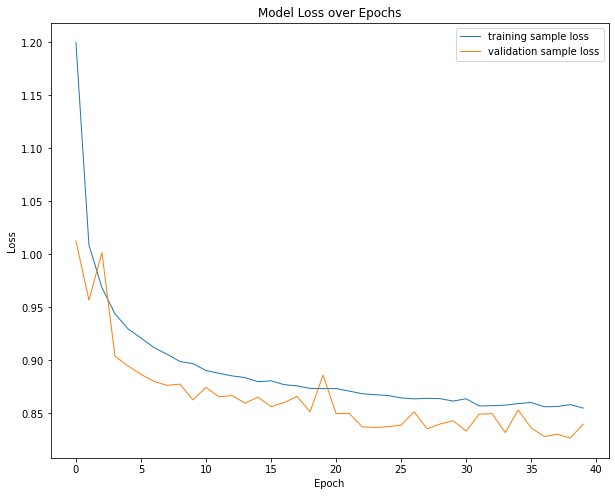

In [11]:
def learningCurve(history):
    plt.figure(figsize=(10,8))
    plt.plot(history.history['loss'], linewidth=1)
    plt.plot(history.history['val_loss'], linewidth=1)
    plt.title('Model Loss over Epochs')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['training sample loss','validation sample loss'])
    plt.savefig('Learning_curve.pdf')
    plt.show()
    plt.close()

learningCurve(history)

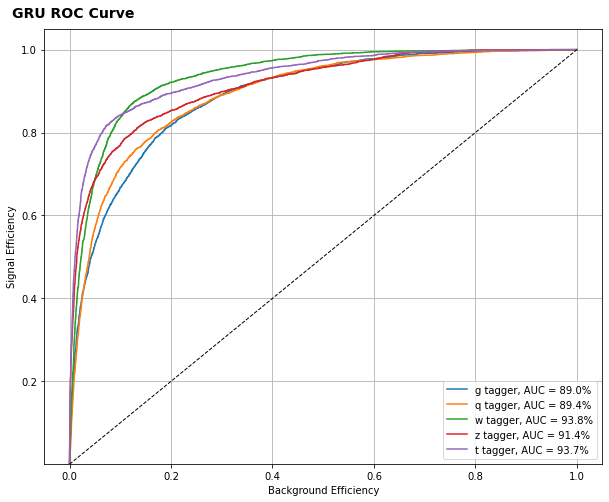

In [14]:
def makeRoc(features_val, labels_val, labels, model, outputDir='', outputSuffix=''):
    from sklearn.metrics import roc_curve, auc
    labels_pred = model.predict(features_val)
    df = pd.DataFrame()
    fpr = {}
    tpr = {}
    auc1 = {}
    plt.figure(figsize=(10,8))
    for i, label in enumerate(labels):
        df[label] = labels_val[:,i]
        df[label + '_pred'] = labels_pred[:,i]
        fpr[label], tpr[label], threshold = roc_curve(df[label],df[label+'_pred'])
        auc1[label] = auc(fpr[label], tpr[label])
        plt.plot(fpr[label],tpr[label],label='%s tagger, AUC = %.1f%%'%(label.replace('j_',''),auc1[label]*100.))
    plt.plot([0, 1], [0, 1], lw=1, color='black', linestyle='--')
    #plt.semilogy()
    plt.xlabel("Background Efficiency")
    plt.ylabel("Signal Efficiency")
    plt.xlim([-0.05, 1.05])
    plt.ylim(0.001,1.05)
    plt.grid(True)
    plt.legend(loc='lower right')
    plt.figtext(0.25, 0.90,'GRU ROC Curve',fontweight='bold', wrap=True, horizontalalignment='right', fontsize=14)
    #plt.figtext(0.35, 0.90,'preliminary', style='italic', wrap=True, horizontalalignment='center', fontsize=14) 
    #plt.savefig('%sROC_%s.pdf'%(outputDir, outputSuffix))
    return labels_pred

y_pred = makeRoc(X_test, y_test, labels, model, outputSuffix='conv1d')